# Optimierung neu

In [1]:
# === 0. Imports ===
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import time


In [2]:

# === 1. Bereits vorverarbeitete Daten laden ===
X_train_res = pd.read_csv("Data/final/X_train_res.csv")
y_train_res = pd.read_csv("Data/final/y_train_res.csv")
X_valid_enc = pd.read_csv("Data/final/X_valid_enc.csv")
X_test_enc = pd.read_csv("Data/final/X_test_enc.csv")
y_valid = pd.read_csv("Data/final/y_valid.csv")
y_test = pd.read_csv("Data/final/y_test.csv")


In [ ]:

# Sicherstellen, dass y-Daten die richtige Form haben
y_train_res = y_train_res.squeeze()
y_test = y_test.squeeze()


# PetID für spätere Analyse extrahieren und aus Features entfernen
test_ids = X_test_enc['PetID']
X_test = X_test_enc.drop(columns=['PetID'])

print("Datenaufteilung:")
print(f"Training: {X_train_res.shape[0]} Samples")
print(f"Test: {X_test.shape[0]} Samples")

### Randomized Search ohne early stopping mit 50 wiederholungen


Starte Randomized Search mit 5-facher Kreuzvalidierung...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Randomized Search abgeschlossen! Dauer: 8.01 Minuten

=== RANDOMIZED SEARCH ERGEBNISSE ===
Beste Parameter: {'subsample': 0.6, 'n_estimators': 600, 'max_depth': 18, 'learning_rate': 0.02}
Beste Genauigkeit (CV): 0.8989912883998166

Top 5 Parameterkombinationen:
                                               params  mean_test_score  \
0   {'subsample': 0.6, 'n_estimators': 600, 'max_d...         0.898991   
5   {'subsample': 0.7, 'n_estimators': 300, 'max_d...         0.898304   
1   {'subsample': 0.8, 'n_estimators': 400, 'max_d...         0.897937   
13  {'subsample': 0.7, 'n_estimators': 300, 'max_d...         0.896790   
10  {'subsample': 1.0, 'n_estimators': 500, 'max_d...         0.893214   

    std_test_score  
0         0.037238  
5         0.038011  
1         0.037429  
13        0.037829  
10        0.037731  

=== FINALE EVALUATION AUF TEST SET ===
Test A

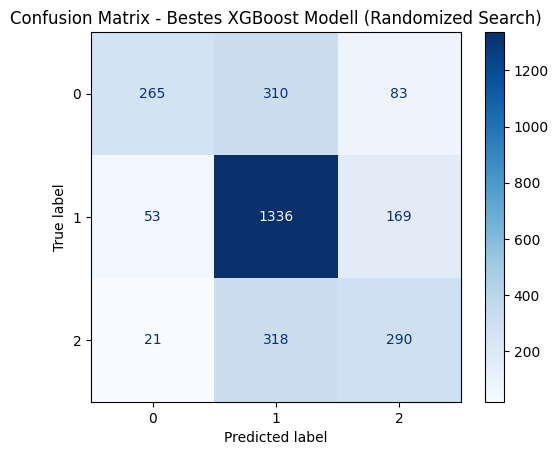

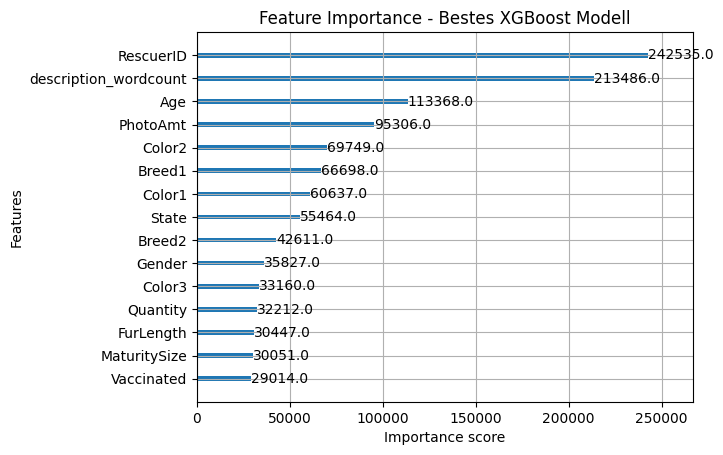


=== VERGLEICH MIT DEFAULT-MODELL ===
Default Modell Accuracy: 0.6231985940246045
Optimiertes Modell Accuracy: 0.6646748681898067
Verbesserung: 0.0415 (4.15%)


In [5]:
# === 2. Randomized Search Parameter ===
param_dist = {
    "n_estimators": [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10, 15, 18],
    "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.7, 0.8, 1.0]
}

# === 3. Randomized Search mit Kreuzvalidierung ===
print("\nStarte Randomized Search mit 5-facher Kreuzvalidierung...")
start_time = time.time()

# Basis-Modell
xgb_base = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    verbosity=0
)

# Randomized Search CV mit 5-facher Kreuzvalidierung
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,  # 30 zufällige Parameterkombinationen
    scoring='accuracy',
    cv=5,  # 5-fache Kreuzvalidierung
    verbose=2,
    random_state=42,
    n_jobs=-1  # Nutzt alle verfügbaren Kerne
)

# Fitte den Randomized Search auf den Trainingsdaten
random_search.fit(X_train_res, y_train_res)

end_time = time.time()
print(f"Randomized Search abgeschlossen! Dauer: {(end_time - start_time)/60:.2f} Minuten")

# === 4. Beste Parameter und Ergebnisse anzeigen ===
print("\n=== RANDOMIZED SEARCH ERGEBNISSE ===")
print("Beste Parameter:", random_search.best_params_)
print("Beste Genauigkeit (CV):", random_search.best_score_)

# Ergebnisse aller Durchläufe anzeigen
results_df = pd.DataFrame(random_search.cv_results_)
print("\nTop 5 Parameterkombinationen:")
top_5 = results_df[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False).head()
print(top_5)

# === 5. Bestes Modell extrahieren ===
best_xgb = random_search.best_estimator_

# === 6. Finale Evaluation auf Testset ===
print("\n=== FINALE EVALUATION AUF TEST SET ===")
y_pred = best_xgb.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

# === 7. Confusion Matrix ===
labels_all = [0, 1, 2]
cm = confusion_matrix(y_test, y_pred, labels=labels_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_all)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Bestes XGBoost Modell (Randomized Search)")
plt.show()

# === 8. Feature Importance ===
plot_importance(best_xgb, importance_type="weight", max_num_features=15)
plt.title("Feature Importance - Bestes XGBoost Modell")
plt.show()

# === 9. Vergleich mit Default-Modell ===
print("\n=== VERGLEICH MIT DEFAULT-MODELL ===")
# Default Modell trainieren
xgb_default = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    verbosity=0
)
xgb_default.fit(X_train_res, y_train_res)
y_pred_default = xgb_default.predict(X_test)

print("Default Modell Accuracy:", accuracy_score(y_test, y_pred_default))
print("Optimiertes Modell Accuracy:", accuracy_score(y_test, y_pred))
improvement = accuracy_score(y_test, y_pred) - accuracy_score(y_test, y_pred_default)
print(f"Verbesserung: {improvement:.4f} ({improvement*100:.2f}%)")


### Randomized Search ohne early stopping mit 100 wiederholungen

### Random Search mit early stopping mit 20 Iterationen

In [23]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === 1. Randomized Search Parameter ===
param_dist = {
    "n_estimators": [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.7, 0.8, 1.0]
}

# === 2. XGBoost Modell ===
xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

# === 3. Randomized Search (ohne Early Stopping hier) ===
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# === 4. Fit Randomized Search ===
random_search.fit(X_train_res, y_train_res)

print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

# === 5. Finale Modell mit Early Stopping ===
best_params = random_search.best_params_

final_xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42,
    **best_params
)

# --- Early Stopping mit Validierungsset ---
final_xgb.fit(
    X_train_res, y_train_res,
    eval_set=[(X_valid, y_valid)],
    early_stopping_rounds=10,   # nur eine Zahl, keine Liste
    verbose=True
)

# === 6. Test-Set Evaluation ===
y_pred = final_xgb.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# === 7. Confusion Matrix ===
labels_all = [0, 1, 2]
cm = confusion_matrix(y_test, y_pred, labels=labels_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_all)
disp.plot(cmap="Blues")
plt.show()

# === 8. Feature Importance ===
plot_importance(final_xgb, importance_type="weight", max_num_features=15)
plt.show()


Fitting 3 folds for each of 20 candidates, totalling 60 fits


exception calling callback for <Future at 0x1b8e6ba2bd0 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\faulh\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\faulh\anaconda3\Lib\multiprocessing\queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\faulh\anaconda3\Lib\site-packages\sklearn\__init__.py", line 82, in <module>
    from .base import clone
  File "c:\Users\faulh\anaconda3\Lib\site-packages\sklearn\base.py", line 17, in <module>
    from .utils import _IS_32BIT
  File "c:\Users\faulh\anaconda3\Lib\site-packages\sklearn\utils\__init__.py", line 19, in <module>
    from .murmurhash import murmurhash3_32
  File "sklearn\

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

### Random Search mit early stopping mit 100 Iterationen

In [ ]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === 1. Randomized Search Parameter ===
param_dist = {
    "n_estimators": [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.7, 0.8, 1.0]
}

# === 2. XGBoost Modell ===
xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

# === 3. Randomized Search (ohne Early Stopping hier) ===
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,
    scoring="accuracy",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# === 4. Fit Randomized Search ===
random_search.fit(X_train_res, y_train_res)

print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

# === 5. Finale Modell mit Early Stopping ===
best_params = random_search.best_params_

final_xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42,
    **best_params
)

# --- Early Stopping mit Validierungsset ---
final_xgb.fit(
    X_train_res, y_train_res,
    eval_set=[(X_valid, y_valid)],
    early_stopping_rounds=10,   # nur eine Zahl, keine Liste
    verbose=True
)

# === 6. Test-Set Evaluation ===
y_pred = final_xgb.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# === 7. Confusion Matrix ===
labels_all = [0, 1, 2]
cm = confusion_matrix(y_test, y_pred, labels=labels_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_all)
disp.plot(cmap="Blues")
plt.show()

# === 8. Feature Importance ===
plot_importance(final_xgb, importance_type="weight", max_num_features=15)
plt.show()
